In [1]:
from time import perf_counter
import os
# from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx

from src import utils
from src import models

SEED = 10
N_CPUS = os.cpu_count()
SAVE = False
SAVE_CSV = False
DECIMATE = 0
PATH = './results/covid/covid'
# np.random.seed(SEED)

In [2]:
def get_list_data(data, sizes, samples):
    if isinstance(samples, int):
        samples = [samples]

    # TODO: properly check data
    assert len(sizes) == len(samples)
    if np.sum(sizes) != data.shape[0]:
        print('WARNING: more nodes available')

    if np.sum(samples) != data.shape[1]:
        print('WARNING: there are more observations available')

    n_nodes = 0
    offset = 0
    data_list = []
    for i, new_nodes in enumerate(sizes):
        n_nodes += new_nodes
        n_samples = samples[i] + offset
        data_list.append( data[:n_nodes, offset:n_samples] )
        offset = n_samples
    return data_list

def visualize_data(data, title):
    # data = data / 10
    Cov = data @ data.T / data.shape[1]
    Prec = np.linalg.inv(Cov) 
    mask = np.ones(Prec.shape[0]) - np.eye(Prec.shape[0])
    fig, axes = plt.subplots(1,3, figsize=(12, 4))
    
    axes[0].plot(data.T)
    axes[0].set_title(title)
    axes[0].grid(True)
    im  = axes[1].imshow(Cov)
    fig.colorbar(im, ax=axes[1])
    axes[1].set_title(title + ' Cov')
    im  = axes[2].imshow(Prec*mask)
    fig.colorbar(im, ax=axes[2])
    axes[2].set_title(title + ' Prec')

## Load and visualize data

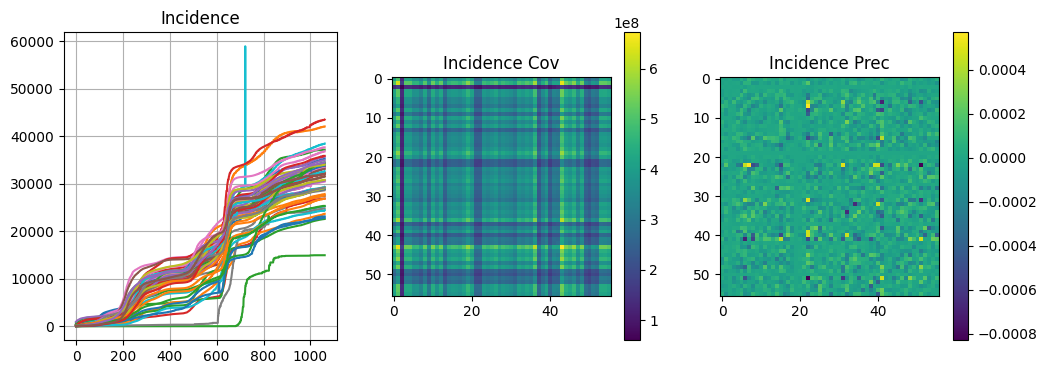

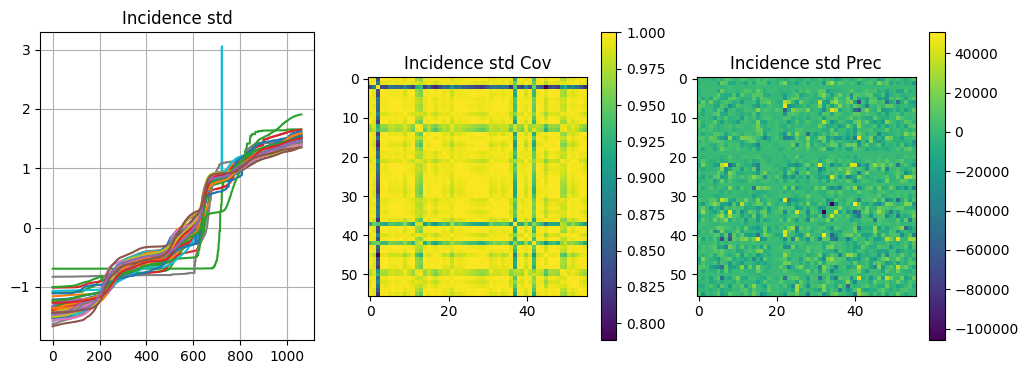

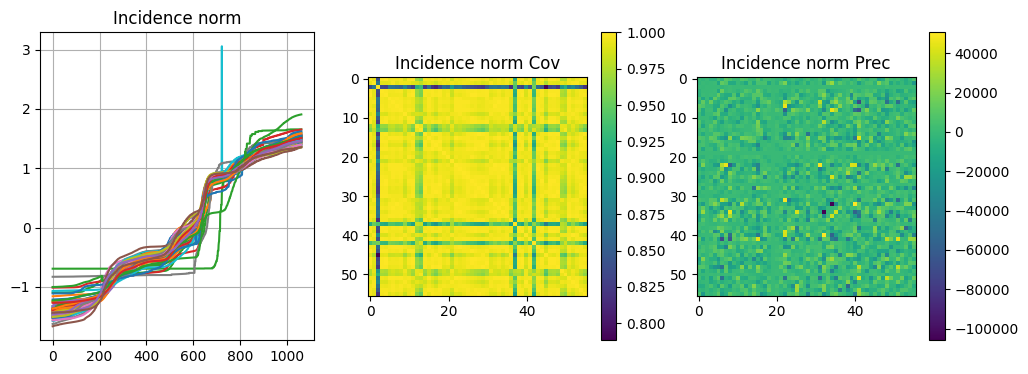

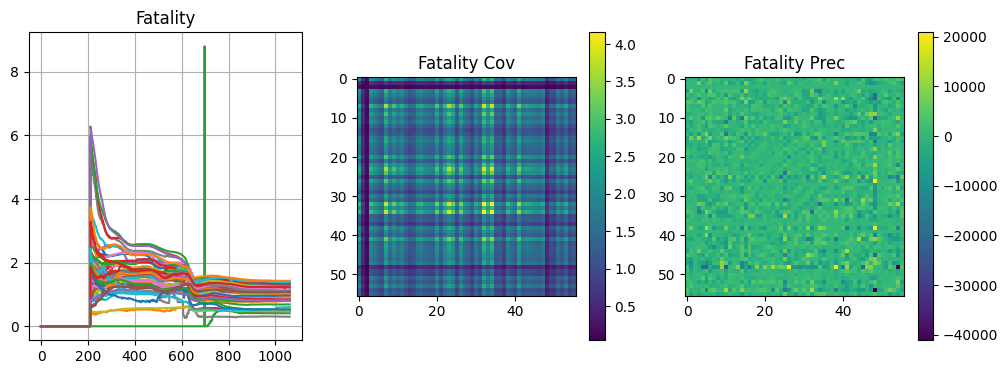

In [3]:
# Prepare data
file_name = 'COVID19/covid_matrices.npz'
data = np.load(file_name, allow_pickle=True)
confirmed = data['confirmed']
deaths = data['deaths']
incidence = data['incidence']
fatality = data['fatality']

MAX_VALUE = fatality.max()

# Standarize
ax = 1
standarize = lambda X, ax: (X - np.nanmean(X, axis=ax, keepdims=True)) / np.nanstd(X, axis=ax, keepdims=True)
normalize = lambda X, ax: X / np.linalg.norm(X, axis=ax, keepdims=True)
confirmed_std = standarize(confirmed, ax)
deaths_std = standarize(deaths, ax)
incidence_std = standarize(incidence, ax)
fatality_std = standarize(fatality, ax)
incidence_norm = standarize(incidence, ax)

# visualize_data(confirmed, 'Confirmed')
# visualize_data(confirmed_std, 'Confirmed std')
visualize_data(incidence, 'Incidence')
visualize_data(incidence_std, 'Incidence std')
visualize_data(incidence_norm, 'Incidence norm')
visualize_data(fatality, 'Fatality')

0.0 8.803611738148984 1.0546971696663399 0.7188732320374114
1.1570963695066578


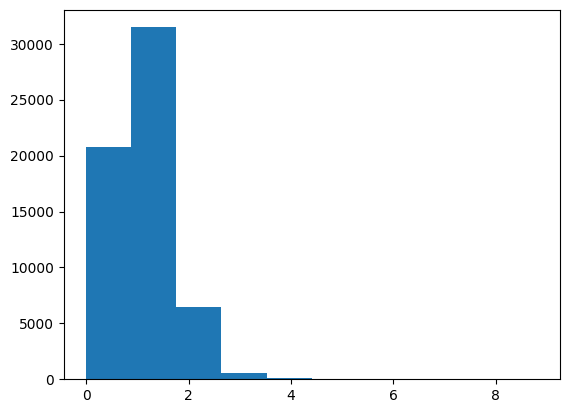

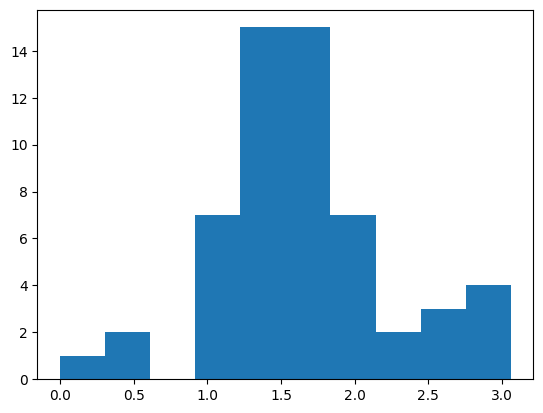

In [4]:
print(fatality.min(), fatality.max(), fatality.mean(), fatality.std())
print(np.median(fatality))

plt.figure()
h = plt.hist(fatality.flatten(), bins=10)

plt.figure()
h = plt.hist(fatality[:,300], bins=10)

# Exps

In [5]:
def run_experiment(Exps, data, sizes, samples, def_args, verb=True):
    X_list = get_list_data(data, sizes, samples)
    n_nodes = data.shape[0]
    n_samples = np.array( [X_i.shape[1] for X_i in X_list] ).sum()

    runtime = np.zeros(len(Exps))
    # err_wrt_off = np.zeros((n_samples, len(Exps)))
    # regret = np.zeros((n_samples, len(Exps)))
    models_fit = []
    for i, exp in enumerate(Exps):
        args_aux = {**def_args, **exp['args']} if 'args' in exp.keys() else {**def_args}
        args_aux['lamb'] = utils.lamb_value(n_nodes, n_samples, args_aux['lamb'])
        model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
        t_init = perf_counter()
        model.fit(X_list, **args_aux)
        t_end = perf_counter()

        if i == 0:
            Adjs_off = model.S_seq.copy()

        runtime[i] = t_end - t_init
        models_fit.append( model ) 

        if verb:
            print(f'- {exp["leg"]}: time: {runtime[i]:.3f} secs')            
        
    return models_fit, Adjs_off, runtime

In [6]:
def compute_errs(models_fit, Adjs_off, n_samples):
    err_wrt_off = np.zeros((n_samples, len(models_fit)))
    regret = np.zeros((n_samples, len(models_fit)))
    for i, model in enumerate(models_fit):
        err_wrt_off[:,i], regret[:,i] = model.regret(Adjs_off) 

    return err_wrt_off,regret

def plot_adjs(model, idxs, title, abs=True):
    fig, axes = plt.subplots(1, len(idxs), figsize=(4*len(idxs), 4))

    for i, idx in enumerate(idxs):
        S_est = model.S_seq[idx[0]][idx[1]]
        mask = np.ones(S_est.shape[0]) - np.eye(S_est.shape[0])
        if abs:
            S_est = np.abs(S_est)

        im = axes[i].imshow(S_est*mask)
        axes[i].set_title(f'{title}-({idx[0]},{idx[1]})')
        fig.colorbar(im, ax=axes[i])

def binarize(Adj, th):
    mask = np.ones(Adj.shape[0]) - np.eye(Adj.shape[0])
    Adj_bin = Adj*mask
    Adj_bin[np.abs(Adj_bin) < th] = 0
    Adj_bin[np.abs(Adj_bin) > th] = 1
    return Adj_bin

def prune_edges(A, max_edges):
    mask = np.ones(A.shape[0]) - np.eye(A.shape[0])
    A = mask*A
    sorted_edges = np.sort(A.flatten())[::-1]
    A_aux = np.copy(A)
    A_aux[A_aux < sorted_edges[max_edges]] = 0
    return A_aux




In [7]:
def get_colors(data, new_nodes, max_val, ths):
    colors = []
    for i in range(data.size - new_nodes):
        # if data[i] >= ths:
        #     colors.append('red')
        # else:
        #     colors.append('yellow')
        # max_value = np.max(data)
        intensity = min(max(data[i] / max_val, .1), 1)  # Clamp intensity between 0 and 1
        color = mcolors.to_hex((intensity, 0, 0))  # Map intensity to red color
        colors.append(color)

    colors += ['green']*new_nodes
    return colors

def plot_graphs(model, idxs, colors_data, title, th=.2, color_ths=1.2, prune=None, layout='spring', save_file=None):
    fig, axes = plt.subplots(1, len(idxs), figsize=(4*len(idxs), 4))

    if prune is not None:
        S_bin = prune_edges(model.S_seq[-1][-1], prune)
    else:
        S_bin = binarize(model.S_seq[-1][-1], th)
        
    if layout == 'circular':
        pos_last = nx.circular_layout(nx.Graph(S_bin))
    else:
        pos_last = nx.spring_layout(nx.Graph(S_bin))

    # Get max_val
    max_val = 0
    for i, idx in enumerate(idxs):
        max_aux = np.max(colors_data[idx[0]][:,idx[1]])
        max_val = max_aux if max_aux > max_val else max_val
    
    for i, idx in enumerate(idxs):
        if prune is not None:
            S_bin = prune_edges(model.S_seq[idx[0]][idx[1]], prune)
        else:
            S_bin = binarize(model.S_seq[idx[0]][idx[1]], th)
        nodes = S_bin.shape[0]

        # if idx[0] > 0:
        if i > 0:
            idx_prev = idxs[i-1]
            new_nodes = model.S_seq[idx[0]][idx[1]].shape[0] - model.S_seq[idx_prev[0]][idx_prev[1]].shape[0]
        else:
            new_nodes = 0

        node_colors = get_colors(colors_data[idx[0]][:,idx[1]], new_nodes, max_val, color_ths)

        pos = {}
        for key, value in pos_last.items():
            if key == nodes:
                break
            pos[key] = value
        
        axes[i].axis('off')
        nx.draw_networkx_edges(nx.Graph(S_bin), 
                            alpha=.6,
                            pos=pos, width=.7,
                            ax = axes[i],
                            # edge_color=edge_color,
                            # edge_cmap=cmap, 
                            # edge_vmin=A_nti_pred.max()*0, 
                            # edge_vmax=A_nti_pred.max()*.3
                            )
        nx.draw_networkx_nodes(nx.Graph(S_bin), 
                            pos=pos, node_size=150, linewidths=1,
                            ax = axes[i],
                            node_color=node_colors,
                            # edgecolors=edge_list
                            )
        axes[i].set_title(f'{title} - ({idx[0]},{idx[1]})')

    if save_file is not None:
        fig.savefig(save_file)
        print('Saved as:', save_file)

In [8]:
# Data params
sizes = [46, 5, 5] #[40,11, 5]
samples = [300, 362, 400] # [362, 300, 400]

# Model parameters
verb = True
COLD_START = False
OFFLINE_ITERS = 100
update = 'incr'
default_args = {
    'iters_sample': 1,
    'lamb': 2, #1e-2,
    'stepsize': 7e-3,
    'gamma':  .97,
    'epsilon': .005,  #1,
    'alpha': 0,
    'nonneg_proj': False
}

In [9]:
Exps = [
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic', 'h': .75}, 'args': {'iters_sample': OFFLINE_ITERS, 'epsilon': .05, 'stepsize': 1e-3, 'lamb': 2}, 'leg': f'Off', 'fmt': '-'}, # Best
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic', 'h': .75}, 'args': {'epsilon': .05, 'stepsize': 1e-3, 'lamb': 2}, 'leg': f'Exp', 'fmt': '-'}, # Best
]
models_fit, Adjs_off, runtime = run_experiment(Exps, incidence_std, sizes, samples, default_args, verb)
fatality_exp = get_list_data(fatality, sizes, samples)

- Off: time: 73.310 secs
- Exp: time: 0.833 secs


Saved as: fatality.png
Saved as: deaths.png


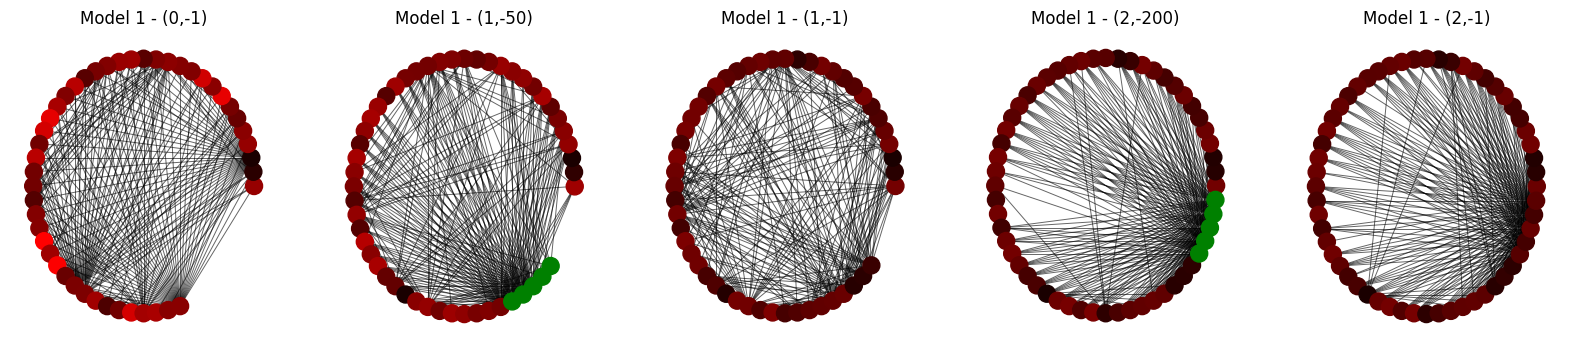

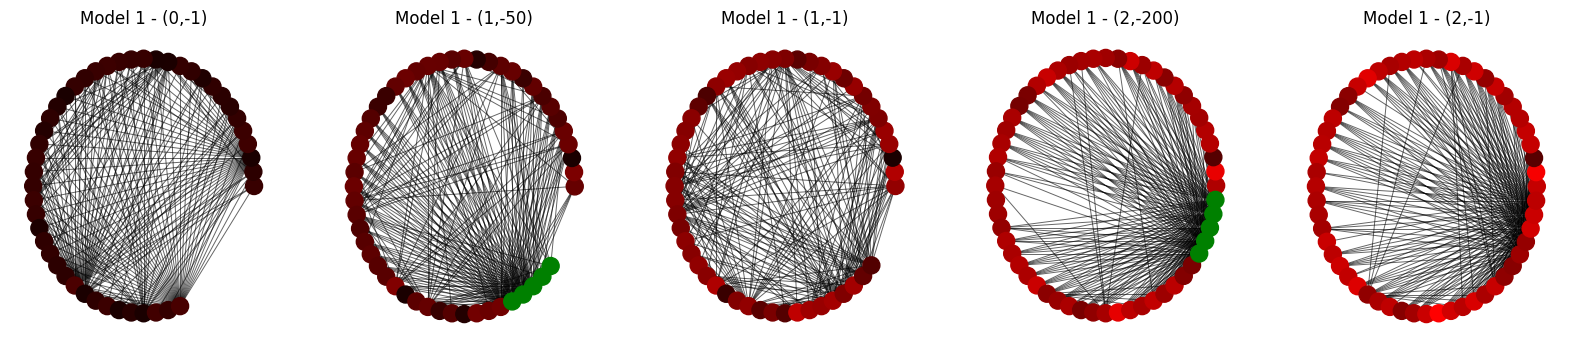

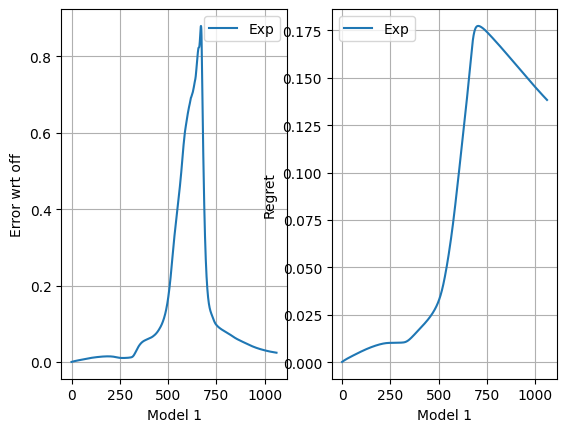

In [10]:
incidence_exp = get_list_data(incidence, sizes, samples)

idxs = [(0,-1), (1,-50), (1,-1), (2,-200), (2,-1)]
# idxs = [(0,150), (0,300), (0,600), (0,850), (0,1000)]
# for i, model in enumerate(models_fit):
i = 1
model = models_fit[i]
plot_graphs(model, idxs, fatality_exp, f'Model {i}', th=0, prune=500, layout='circular', save_file='fatality.png')
plot_graphs(model, idxs, incidence_exp, f'Model {i}', th=0, prune=500, layout='circular', save_file='deaths.png')

err_off, regret = compute_errs([model], Adjs_off, np.sum(samples))
fig, axes = plt.subplots(1,2)
utils.plot_data(axes[0], err_off, [Exps[i]], np.arange(err_off.shape[0]), f'Model {i}', 'Error wrt off',
                        agg=None, deviation='none', dec=DECIMATE)
utils.plot_data(axes[1], regret, [Exps[i]], np.arange(regret.shape[0]), f'Model {i}', 'Regret',
                        agg=None, deviation='none', dec=DECIMATE)
fig.savefig('err_regret.png')

In [23]:
Exps = [
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic','h': .75}, 'args': {'iters_sample': OFFLINE_ITERS, 'epsilon': .05, 'stepsize': 1e-3, 'lamb': .1}, 'leg': f'Off', 'fmt': '-'}, # Best
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic','h': .75}, 'args': {'epsilon': .05, 'stepsize': 2e-3, 'lamb': .1}, 'leg': f'Exp', 'fmt': '-'}, # Best
]
models_fit, Adjs_off, runtime = run_experiment(Exps, incidence_std, sizes, samples, default_args, verb)
fatality_exp = get_list_data(fatality, sizes, samples)

- Off: time: 85.255 secs
- Exp: time: 0.866 secs


Saved as: fatality_aux.png
Saved as: deaths_aux.png


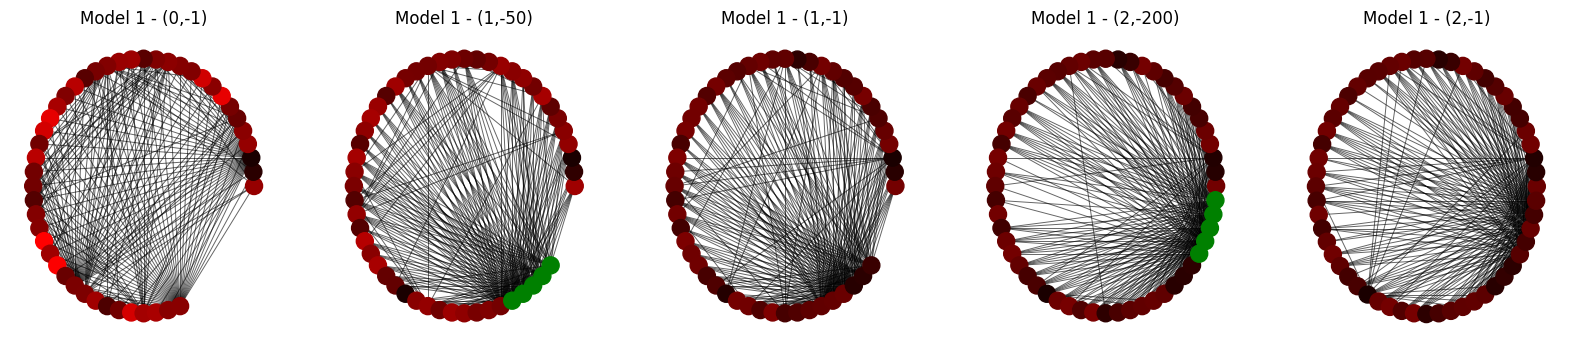

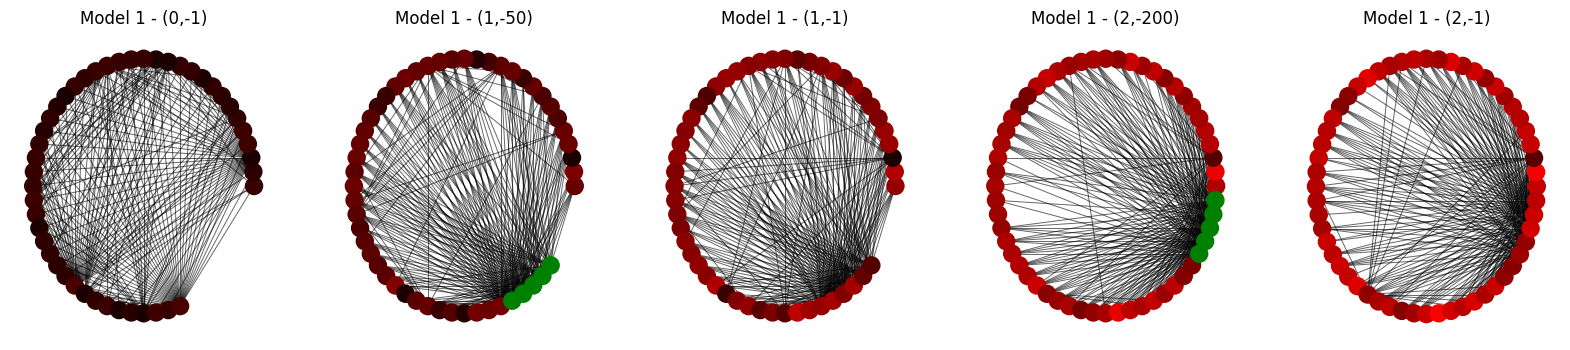

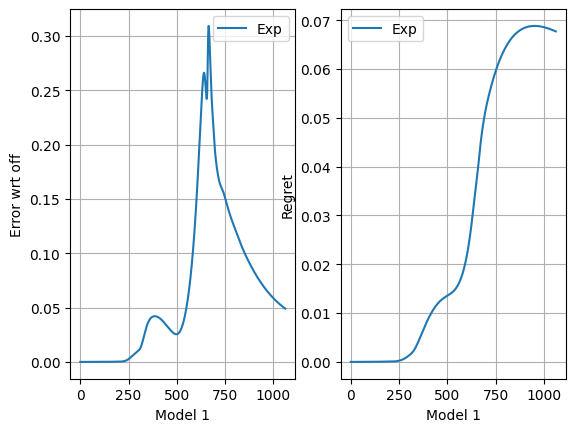

In [24]:
incidence_exp = get_list_data(incidence, sizes, samples)

idxs = [(0,-1), (1,-50), (1,-1), (2,-200), (2,-1)]
i = 1
model = models_fit[i]
plot_graphs(model, idxs, fatality_exp, f'Model {i}', th=0, prune=500, layout='circular', save_file='fatality_aux.png')
plot_graphs(model, idxs, incidence_exp, f'Model {i}', th=0, prune=500, layout='circular', save_file='deaths_aux.png')

err_off, regret = compute_errs([model], Adjs_off, np.sum(samples))
fig, axes = plt.subplots(1,2)
utils.plot_data(axes[0], err_off, [Exps[i]], np.arange(err_off.shape[0]), f'Model {i}', 'Error wrt off',
                        agg=None, deviation='none', dec=DECIMATE)
utils.plot_data(axes[1], regret, [Exps[i]], np.arange(regret.shape[0]), f'Model {i}', 'Regret',
                        agg=None, deviation='none', dec=DECIMATE)
fig.savefig('err_regret_aux.png')

In [13]:
# Exps = [
#     {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'args': {'iters_sample': OFFLINE_ITERS, 'epsilon': .1, 'stepsize': 1e-3, 'lamb': 2}, 'leg': f'Exp', 'fmt': '-'}, # Best
#     {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'args': {'epsilon': .1, 'stepsize': 1e-3, 'lamb': 2}, 'leg': f'Exp', 'fmt': '-'}, # Best
# ]
# models_fit, Adjs_off, runtime = run_experiment(Exps, incidence_std, sizes, samples, default_args, verb)
# fatality_exp = get_list_data(fatality, sizes, samples)

In [14]:
# incidence_exp = get_list_data(incidence, sizes, samples)

# idxs = [(0,-1), (1,-50), (1,-1), (2,-200), (2,-1)]
# # idxs = [(0,150), (0,300), (0,600), (0,850), (0,1000)]
# # for i, model in enumerate(models_fit):
# i = 1
# model = models_fit[i]
# plot_graphs(model, idxs, fatality_exp, f'Model {i}', th=0, prune=500, layout='circular')
# plot_graphs(model, idxs, incidence_exp, f'Model {i}', th=0, prune=500, layout='circular')

# err_off, regret = compute_errs([model], Adjs_off, np.sum(samples))
# fig, axes = plt.subplots(1,2)
# utils.plot_data(axes[0], err_off, [Exps[i]], np.arange(err_off.shape[0]), f'Model {i}', 'Error wrt off',
#                         agg=None, deviation='none', dec=DECIMATE)
# utils.plot_data(axes[1], regret, [Exps[i]], np.arange(regret.shape[0]), f'Model {i}', 'Regret',
#                         agg=None, deviation='none', dec=DECIMATE)

## Incidence

In [15]:
# Exps = [
#     {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'args': {'iters_sample': OFFLINE_ITERS, 'epsilon': .1, 'stepsize': 1e-3, 'lamb': 2}, 'leg': f'Exp', 'fmt': '-'}, # Best
#     {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'args': {'epsilon': .1, 'stepsize': 1e-3, 'lamb': 2}, 'leg': f'Exp', 'fmt': '-'}, # Best
# ]
# models_fit, Adjs_off, runtime = run_experiment(Exps, incidence_norm, sizes, samples, default_args, verb)
# fatality_exp = get_list_data(fatality, sizes, samples)

In [16]:
# incidence_exp = get_list_data(incidence, sizes, samples)

# idxs = [(0,-1), (1,-50), (1,-1), (2,-200), (2,-1)]
# # idxs = [(0,150), (0,300), (0,600), (0,850), (0,1000)]
# # for i, model in enumerate(models_fit):
# i = 1
# model = models_fit[i]
# plot_graphs(model, idxs, fatality_exp, f'Model {i}', th=0, prune=500, layout='circular')
# plot_graphs(model, idxs, incidence_exp, f'Model {i}', th=0, prune=500, layout='circular')

# err_off, regret = compute_errs([model], Adjs_off, np.sum(samples))
# fig, axes = plt.subplots(1,2)
# utils.plot_data(axes[0], err_off, [Exps[i]], np.arange(err_off.shape[0]), f'Model {i}', 'Error wrt off',
#                         agg=None, deviation='none', dec=DECIMATE)
# utils.plot_data(axes[1], regret, [Exps[i]], np.arange(regret.shape[0]), f'Model {i}', 'Regret',
#                         agg=None, deviation='none', dec=DECIMATE)

## Incidence / 1e4

In [17]:
Exps = [
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'args': {'iters_sample': OFFLINE_ITERS, 'epsilon': .1, 'stepsize': 1e-3, 'lamb': 2}, 'leg': f'Exp', 'fmt': '-'}, # Best
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'args': {'epsilon': .1, 'stepsize': 1e-3, 'lamb': 2}, 'leg': f'Exp', 'fmt': '-'}, # Best
]
models_fit, Adjs_off, runtime = run_experiment(Exps, incidence/1e4, sizes, samples, default_args, verb)

- Exp: time: 79.490 secs
- Exp: time: 0.835 secs


Saved as: fatality2.png
Saved as: deaths2.png


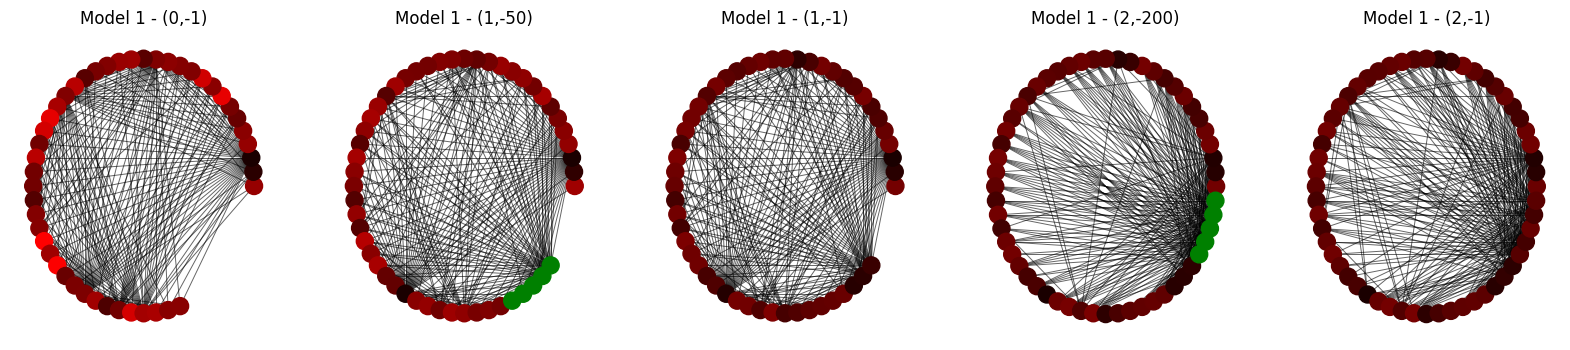

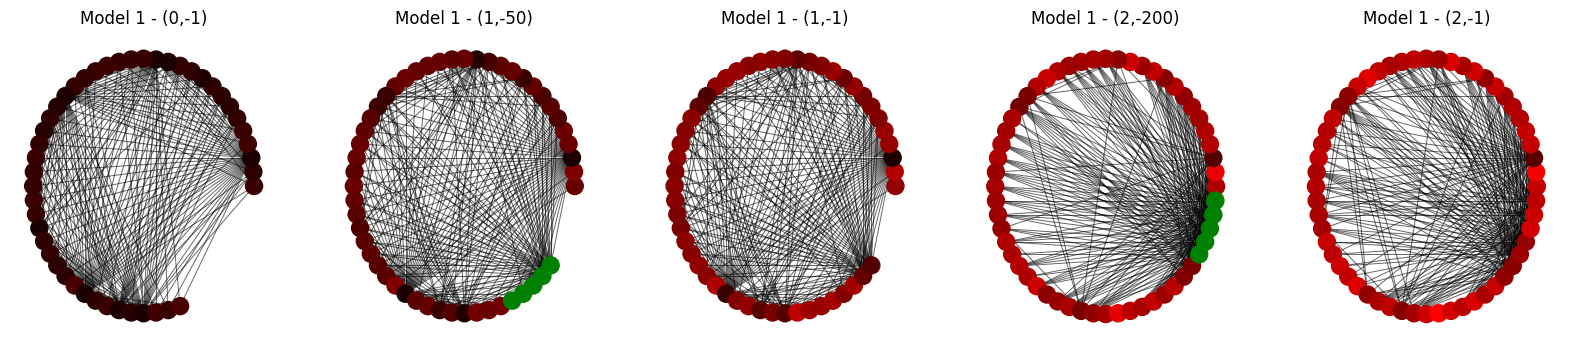

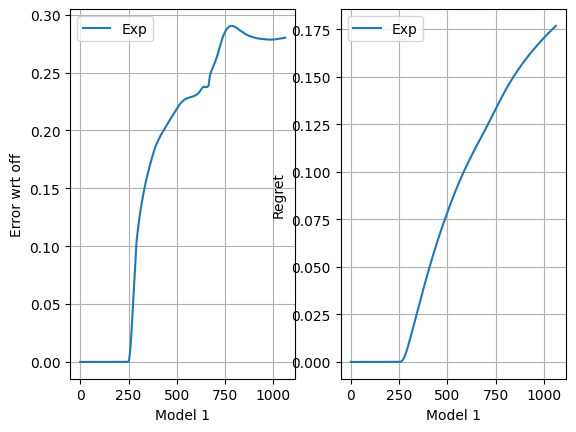

In [18]:
incidence_exp = get_list_data(incidence, sizes, samples)

idxs = [(0,-1), (1,-50), (1,-1), (2,-200), (2,-1)]
# idxs = [(0,150), (0,300), (0,600), (0,850), (0,1000)]
# for i, model in enumerate(models_fit):
i = 1
model = models_fit[i]
plot_graphs(model, idxs, fatality_exp, f'Model {i}', th=0, prune=500, layout='circular', save_file='fatality2.png')
plot_graphs(model, idxs, incidence_exp, f'Model {i}', th=0, prune=500, layout='circular', save_file='deaths2.png')

err_off, regret = compute_errs([model], Adjs_off, np.sum(samples))
fig, axes = plt.subplots(1,2)
utils.plot_data(axes[0], err_off, [Exps[i]], np.arange(err_off.shape[0]), f'Model {i}', 'Error wrt off',
                        agg=None, deviation='none', dec=DECIMATE)
utils.plot_data(axes[1], regret, [Exps[i]], np.arange(regret.shape[0]), f'Model {i}', 'Regret',
                        agg=None, deviation='none', dec=DECIMATE)
fig.savefig('err_regret2.png')